# ASE2020 submission id #302 -- iCPD

07-05-2020 XXXXXXXXXXX


In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy.stats import norm

sns.set_style('white')
sns.set_context('talk')

np.random.seed(77)

## 1. Now, the first step is to generate some runtime data

In [2]:
expected_w_time=600 #the window size in seconds 
expected_cp_time = 100 # the ground truth change point index in that window


the_a = 6.0 # the ground truth transition rate before cp
the_num_tran_before_cp=int(expected_cp_time*the_a)
data_before_cp = np.random.exponential(1/the_a, the_num_tran_before_cp)

#print(sum(data_before_cp),np.mean(data_before_cp),len(data_before_cp),the_num_tran_before_cp)

the_b = 2 # the ground truth transition rate after cp
the_num_tran_after_cp=int(the_b*(expected_w_time-expected_cp_time))
data_after_cp = np.random.exponential(1/the_b, the_num_tran_after_cp)

#print(sum(data_after_cp),np.mean(data_after_cp),len(data_after_cp),the_num_tran_after_cp)

raw_data=np.append(data_before_cp,data_after_cp)
#print(np.sum(raw_data[0:the_num_tran_before_cp]),
      #sum(raw_data[the_num_tran_before_cp:the_num_tran_before_cp+the_num_tran_after_cp]),
      #sum(raw_data),len(raw_data))
        
the_cp_time=sum(data_before_cp)
w_time=sum(raw_data)

w=len(raw_data)
the_cp=len(data_before_cp)

print('the ground truth change point time is {0}'.format(the_cp_time))
print('the ground truth time window is {0}'.format(w_time))
print('number of transitions before cp {0}'.format(the_cp))
print('total number of transitions {0}'.format(w))

the ground truth change point time is 94.2510106835536
the ground truth time window is 588.3326203770014
number of transitions before cp 600
total number of transitions 1600


In [3]:
data=np.cumsum(raw_data) #reshape the data by accumulated sum
print(data)

[4.19108850e-01 5.90403652e-01 8.23946090e-01 ... 5.87444435e+02
 5.87864160e+02 5.88332620e+02]


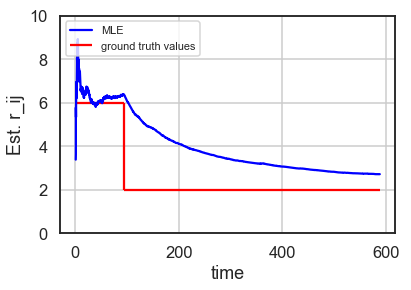

In [4]:
# first, let us play with a MLE estimator..
r_MLE=np.array([])
i=1
while i<=len(data) :
    r_MLE=np.append(r_MLE,i/data[i-1])
    i=i+1

plt.plot(data[1:],r_MLE[1:],linestyle='-',color='b',label='MLE')

plt.hlines(y=the_a,xmin=0,xmax=the_cp_time,
           color='r', linestyle='-',label='ground truth values')
plt.hlines(y=the_b,xmin=the_cp_time,xmax=w_time,
           color='r',linestyle='-' )
plt.vlines(x=the_cp_time,ymin=the_a,ymax=the_b,
           color='r',linestyle='-' )

plt.ylim([0,10])
plt.legend(loc='upper left',fontsize=11)
plt.xlabel('time')
plt.ylabel('Est. r_ij')
plt.grid(True)

plt.show()

## 2. Use IPSP to estimate the $r_{ij}$ given the simulated data

In [5]:
# this is the IPSP estimator
def IPSP_est_pij(ti, nij, c_prior_lower, c_prior_upper, rij_prior_lower, rij_prior_upper):
#define function to use sets of priors to update transition probabilityes r_ij 
#the t_i is the totoal holding time in state i
#the n_ij is the number of transtions from i to j.
#the other 4 parameters are defining the set of priors of IPSP
    rij_post_lower=0
    rij_post_upper=0

    if(ti==0):
        return rij_prior_lower, rij_prior_upper
    if(nij/ti) >= rij_prior_lower:
        rij_post_lower=(c_prior_upper*rij_prior_lower+nij)/(c_prior_upper+ti)
        
    if(nij/ti) < rij_prior_lower:
        rij_post_lower=(c_prior_lower*rij_prior_lower+nij)/(c_prior_lower+ti)
        
    if (nij/ti) <= rij_prior_upper:
        rij_post_upper=(c_prior_upper*rij_prior_upper+nij)/(c_prior_upper+ti)
        
    if (nij/ti) > rij_prior_upper:
        rij_post_upper=(c_prior_lower*rij_prior_upper+nij)/(c_prior_lower+ti)
        

    return rij_post_lower, rij_post_upper

In [6]:
IPSP_est_upper=[]
IPSP_est_lower=[]
IPSP_est_diff=[] #the difference between the lower and upper bounds

#the 4 parameters defining the sets of priors
t_prior_lower=200
t_prior_upper=400
rij_prior_lower=5.5
rij_prior_upper=6.5

timer=0
while timer<=w_time:
    temp_index=0
    temp_index = np.argmax(data>= timer)# the index of the array that bigger than timer..
    
    temp_lower, temp_upper=IPSP_est_pij(timer,temp_index,
                                        t_prior_lower,t_prior_upper,
                                        rij_prior_lower,rij_prior_upper)
    #print(temp_lower, temp_upper)
    IPSP_est_lower.append(temp_lower)
    IPSP_est_upper.append(temp_upper)
    IPSP_est_diff.append(temp_upper-temp_lower)
    
    timer=timer+1# every 1 seconds invoke a IPSP estimation
    
print(len(IPSP_est_diff))

589


In [7]:
int(w_time)

588

range(0, 589)


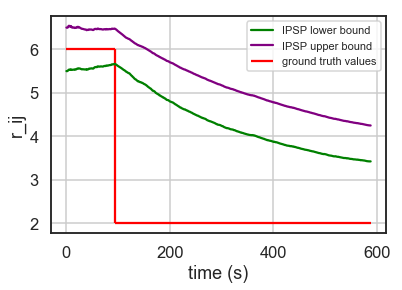

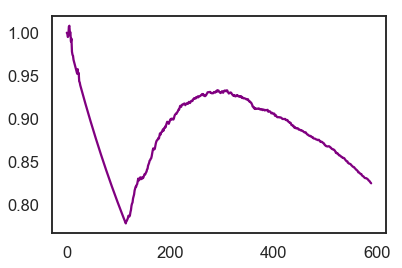

In [8]:

x_index = range(0,int(w_time)+1,1)#only for aiding the plots...

print(x_index)
plt.hlines(y=the_a,xmin=0,xmax=the_cp_time,
           color='r', linestyle='-',label='ground truth values')
plt.hlines(y=the_b,xmin=the_cp_time,xmax=w_time,
           color='r',linestyle='-' )
plt.vlines(x=the_cp_time,ymin=the_a,ymax=the_b,
           color='r',linestyle='-' )

plt.plot(x_index,IPSP_est_lower,linestyle='-',color='green',label='IPSP lower bound')
plt.plot(x_index,IPSP_est_upper,linestyle='-',color='purple',label='IPSP upper bound')

#plt.axis([0, w, 0, 1])# set the ranges of axis
plt.legend(fontsize=11)
plt.xlabel('time (s)')
plt.ylabel('r_ij')
plt.grid(True)

plt.show()

plt.plot(x_index,IPSP_est_diff,linestyle='-',color='purple',label='IPSP bound width')
plt.show()

## 3. The trigger of CPD

In [9]:

the_tp_time=0# the trigger point
timer=0#the trigger point only
while timer<w_time:
    # and ignore the first x seconds (e.g., 100 seconds)
    if timer>150 and IPSP_est_diff[timer]-IPSP_est_diff[timer-1]>0:
        the_tp_time=timer
        break
    timer=timer+1

In [10]:
#now the window of the data is from 0 to the_tp
if the_tp_time==0:
    print('no CPD analysis is triggered at ignore what follows...')
else:
    #print('the tirgier point is at {0} index'.format(the_tp))
    print('the tirgier point is at {0}s time'.format(the_tp_time))
    the_tp_index=np.argmax(data>= the_tp_time)
    print('the tirgier point index is at {0}'.format(the_tp_index))
    

the tirgier point is at 152s time
the tirgier point index is at 728


## 4. The CPD analysis

Now let us define our likelihood function

In [11]:
# note the x arguments in the functions below are time 

def N(x):
    # return the number of transitions before the x point 
    # and only use data up to the trigger point..
    return np.argmax(data[0:the_tp_index]>= x)
     
def M(x):
    # return the number of transitions after the x point 
    # and only use data up to the trigger point..
    return len(data[0:the_tp_index])-np.argmax(data>= x)

def log_likelihood(x):
    # simply the exponentional likelihood, I am using log now..
    a=(N(x)/x) #x!=0
    b=(M(x)/(the_tp_time-x))# note, here w!=x..
    #print(a,b,N(x),M(x))
    #return np.exp(N(x)*math.log(N(x))+M(x)*math.log(M(x))-math.log(math.factorial(N(x)))-math.log(math.factorial(M(x)))-N(x)-M(x))
    #return sp.stats.poisson.pmf(N(x),N(x))*sp.stats.poisson.pmf(M(x),M(x))
    return -a*x+N(x)*math.log(a)-b*(the_tp_time-x)+M(x)*math.log(b)

    


Now let us do MCMC samplings...

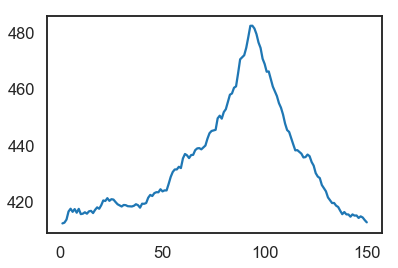

In [12]:

#this code is to visualise the likelihood
def h(b):
    l = []
    for i in b:
        l.append((log_likelihood(i)))
    return l
t = np.arange(1, the_tp_time-1, 1)
plt.plot(t, h(t))
plt.show()


In [13]:
x_current = the_tp_time/2 #starting point of MCMC
x_posterior=[x_current] 
samples=15000 # number of samples
std=2#the std of the proposal dist. which needs to be fine tuned
test=[1]

for i in range(samples):
    # step 1: from a symetrical normal dist., sample a proposed x 
    
    proposal = np.random.normal(x_current, std, 1) 
    
    while proposal[0]<=1 or proposal[0]>=the_tp_time-1: #the proposal x cannot 0 or the trigger point
        proposal = np.random.normal(x_current, std, 1)

    proposal=proposal[0]
    #print(proposal)
    #step 2: let us decide if we accpet that proposal or not.
    log_likelihood_current =log_likelihood(x_current)
    log_likelihood_proposal =log_likelihood(proposal)

    # Compute prior probability of current and proposed x        
    prior_current = 1/the_tp_time #here we assume prior x is unifomly distributed, but you can use others\\
    prior_proposal = 1/the_tp_time # for sure, then you change here..

    # Nominator of Bayes formula
    #p_current = likelihood_current #* prior_current
    #p_proposal = likelihood_proposal #* prior_proposal

    p_accept = np.exp(log_likelihood_proposal-log_likelihood_current)#p_accept = p_proposal / p_current
    #print(p_accept)

    accept = np.random.rand() < p_accept
    test.append(accept) # record the number of proposals being accpeted for fine tune.

    # if accpet then change the x_current and put the accpected sample in to posterior

    if accept:
    # Update position
        x_current = proposal
        x_posterior.append(x_current)



Text(74.04676394109933, 0.1, 'Variance=1.497870')

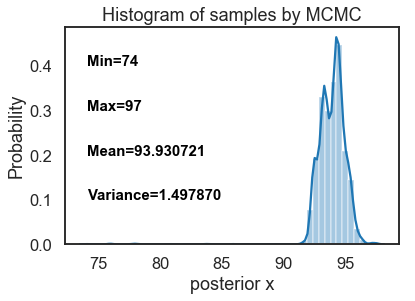

In [14]:
ax = plt.subplot()
sns.distplot(x_posterior, ax=ax, kde=True, hist=True)
_ = ax.set(title='Histogram of samples by MCMC', xlabel='posterior x', ylabel='Probability');

ax.text(min(x_posterior),0.4,'Min=%d'%min(x_posterior),size=15, color='black', weight='semibold')
ax.text(min(x_posterior),0.3,'Max=%d'%max(x_posterior),size=15, color='black', weight='semibold')
ax.text(min(x_posterior),0.2,'Mean=%f'%sp.mean(x_posterior),size=15, color='black', weight='semibold')
ax.text(min(x_posterior),0.1,'Variance=%f'%sp.var(x_posterior),size=15, color='black', weight='semibold')


In [15]:
print(sum(test)/samples)# tune the std in the MCMC, good range is 0.2-0.5
print(sum(test))

0.3176
4764


In [16]:
# correspondingly the posterior for b is
def calulate_b_post(x_post):
    b_post = []
    for i in x_post:
        b_post.append((M(i))/(the_tp_time-i))
    return b_post

b_posterior=calulate_b_post(x_posterior)

Text(2.2165160662088432, 1, 'Variance=0.003392')

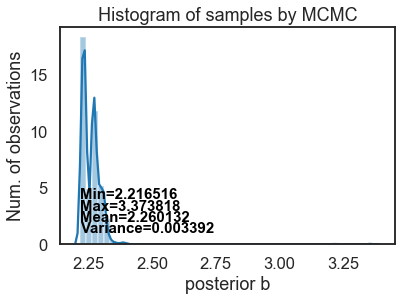

In [17]:

ax = plt.subplot()

sns.distplot(b_posterior, ax=ax, kde=True, hist=True)
_ = ax.set(title='Histogram of samples by MCMC', xlabel='posterior b', ylabel='Num. of observations');

ax.text(min(b_posterior),4,'Min=%f'%min(b_posterior),size=15, color='black', weight='semibold')
ax.text(min(b_posterior),3,'Max=%f'%max(b_posterior),size=15, color='black', weight='semibold')
ax.text(min(b_posterior),2,'Mean=%f'%sp.mean(b_posterior),size=15, color='black', weight='semibold')
ax.text(min(b_posterior),1,'Variance=%f'%sp.var(b_posterior),size=15, color='black', weight='semibold')

Now do some statistics on the two posterior distributions

In [18]:
print(sp.stats.describe(x_posterior))
print(sp.stats.describe(b_posterior))

DescribeResult(nobs=4764, minmax=(74.04676394109933, 97.58110858644773), mean=93.93072138598365, variance=1.4981841148425095, skewness=-5.498974477577792, kurtosis=73.99537674513378)
DescribeResult(nobs=4764, minmax=(2.2165160662088432, 3.3738176026621893), mean=2.2601318913120076, variance=0.0033930416571719643, skewness=11.73284309533841, kurtosis=194.07513888181757)


## 5. The new IPSP+CPD run time estimates on $r_{ij}$.

First, based on the CPD analysis, we use the mean of the posterior distribution of x as the estimated change point.

In [19]:
est_x=(np.mean(x_posterior))# this is time
est_x_index=np.argmax(data>= est_x)
print(est_x,est_x_index)

93.93072138598365 596


Now, before the change point, the IPSP estimates are:

In [20]:
IPSP_est_upper_before_cp=[]
IPSP_est_lower_before_cp=[]
IPSP_est_diff_before_cp=[] #the difference between the lower and upper bounds

#the 4 parameters defining the sets of priors
t_prior_lower=200
t_prior_upper=400
rij_prior_lower=5.5
rij_prior_upper=6.5

timer=0
while timer<=est_x:#before the cp
    
    temp_index=0
    temp_index = np.argmax(data>= timer)# the index of the array that bigger than timer..
    
    temp_lower, temp_upper=IPSP_est_pij(timer,temp_index,
                                        t_prior_lower,t_prior_upper,
                                        rij_prior_lower,rij_prior_upper)
    #print(temp_lower, temp_upper)
    IPSP_est_lower_before_cp.append(temp_lower)
    IPSP_est_upper_before_cp.append(temp_upper)
    IPSP_est_diff_before_cp.append(temp_upper-temp_lower)
    
    timer=timer+1# every 1 seconds invoke a IPSP estimation

In [21]:
IPSP_est_upper_after_cp=[]
IPSP_est_lower_after_cp=[]
IPSP_est_diff_after_cp=[] #the difference between the lower and upper bounds

#the 4 parameters defining the sets of priors
t_prior_lower=the_tp_time-max(x_posterior)
t_prior_upper=the_tp_time-min(x_posterior)
rij_prior_lower=1*np.min(b_posterior)
rij_prior_upper=1*np.quantile(b_posterior,1)
# we could make the intial bounds wider or narrower if we see outliers
# in this case, there *are* outliers, so we use a 90% quantile 

print(t_prior_lower,t_prior_upper,rij_prior_lower,rij_prior_upper)

timer=est_x
while timer<=w_time: #from the cp to the end of data window
    
    temp_index=0
    temp_index = np.argmax(data>= timer)# the index of the array that bigger than timer..
    temp_index=temp_index-est_x_index
    
    temp_lower, temp_upper=IPSP_est_pij(timer-est_x,temp_index,
                                        t_prior_lower,t_prior_upper,
                                        rij_prior_lower,rij_prior_upper)
    #print(temp_lower, temp_upper)
    IPSP_est_lower_after_cp.append(temp_lower)
    IPSP_est_upper_after_cp.append(temp_upper)
    IPSP_est_diff_after_cp.append(temp_upper-temp_lower)
    
    timer=timer+1# every 1 seconds invoke a IPSP estimation

54.418891413552274 77.95323605890067 2.2165160662088432 3.3738176026621893


In [22]:
new_IPSP_est_upper=np.append(IPSP_est_upper_before_cp,IPSP_est_upper_after_cp)
new_IPSP_est_lower=np.append(IPSP_est_lower_before_cp,IPSP_est_lower_after_cp)
new_IPSP_est_diff=np.append(IPSP_est_diff_before_cp,IPSP_est_diff_after_cp)

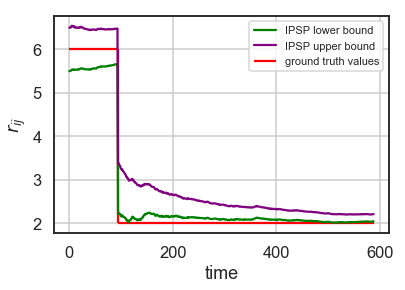

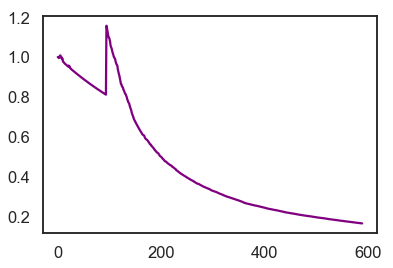

In [23]:
x_index = range(0,math.ceil(w_time),1)#only for aiding the plots...

plt.hlines(y=the_a,xmin=0,xmax=the_cp_time,
           color='r', linestyle='-',label='ground truth values')
plt.hlines(y=the_b,xmin=the_cp_time,xmax=w_time,
           color='r',linestyle='-' )
plt.vlines(x=the_cp_time,ymin=the_a,ymax=the_b,
           color='r',linestyle='-' )

plt.plot(x_index,new_IPSP_est_lower[:],linestyle='-',color='green',label='IPSP lower bound')
plt.plot(x_index,new_IPSP_est_upper[:],linestyle='-',color='purple',label='IPSP upper bound')

#plt.axis([0, w, 0, 1])# set the ranges of axis
plt.legend(fontsize=11)
plt.xlabel('time')
plt.ylabel('$r_{ij}$')
plt.grid(True)

plt.show()

plt.plot(x_index,new_IPSP_est_diff[:],linestyle='-',color='purple',label='IPSP bound width')
plt.show()


Now, since we are both scientist and artist at the same time, we would like to present this kind of figures:

In [24]:
print(w)

1600


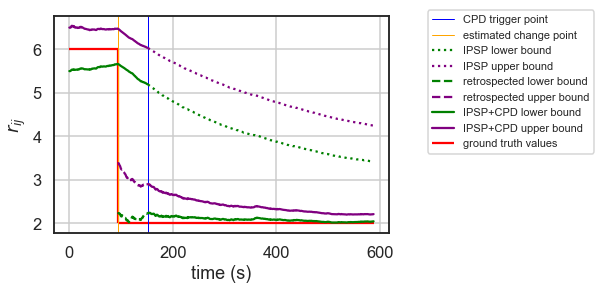

In [25]:
timer=range(0,math.ceil(w_time),1)

plt.hlines(y=the_a,xmin=0,xmax=the_cp_time,
           color='r', linestyle='-',label='ground truth values')
plt.hlines(y=the_b,xmin=the_cp_time,xmax=w_time,
           color='r',linestyle='-' )
plt.vlines(x=the_cp_time,ymin=the_a,ymax=the_b,
           color='r',linestyle='-' )


plt.axvline(x=the_tp_time, linestyle='-',color='b',label='CPD trigger point',linewidth=1)
plt.axvline(x=est_x, linestyle='-',color='orange',label='estimated change point',linewidth=1)


plt.plot(IPSP_est_lower[:math.ceil(the_tp_time)],linestyle='-',color='green')
plt.plot(IPSP_est_upper[:math.ceil(the_tp_time)] ,linestyle='-',color='purple')
plt.plot(timer[math.ceil(the_tp_time):],IPSP_est_lower[math.ceil(the_tp_time):],linestyle='dotted',color='green',label='IPSP lower bound')
plt.plot(timer[math.ceil(the_tp_time):],IPSP_est_upper[math.ceil(the_tp_time):],linestyle='dotted',color='purple',label='IPSP upper bound')

#print(est_x_index,the_tp_index)
#print(len(IPSP_est_lower))

plt.plot(timer[math.ceil(est_x):math.ceil(the_tp_time)],new_IPSP_est_lower[math.ceil(est_x):math.ceil(the_tp_time)],label='retrospected lower bound', linestyle='dashed',color='green')
plt.plot(timer[math.ceil(est_x):math.ceil(the_tp_time)],new_IPSP_est_upper[math.ceil(est_x):math.ceil(the_tp_time)],label='retrospected upper bound', linestyle='dashed',color='purple')
plt.plot(timer[math.ceil(the_tp_time):],new_IPSP_est_lower[math.ceil(the_tp_time):],label='IPSP+CPD lower bound', linestyle='-',color='green')
plt.plot(timer[math.ceil(the_tp_time):],new_IPSP_est_upper[math.ceil(the_tp_time):],label='IPSP+CPD upper bound', linestyle='-',color='purple')

#plt.axis([0, w, 0, 1])# set the ranges of axis
plt.legend(fontsize=11,bbox_to_anchor=(1.1, 1.05))
plt.xlabel('time (s)')
plt.ylabel('$r_{ij}$')
plt.grid(True)

plt.show()
